#Classification of Water Consumption Types

[Assignment SI - Infos](https://drive.google.com/file/d/1lh5a0YxVsC-NXtsIpucTVCrfJR_8KZB4/view?usp=sharing)

[Dataset Train](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/train.csv)

[Dataset Competition](https://virtual.ipb.pt/access/content/group/5b961040-5442-11ee-bfc7-421e367e2b5a/Assignment/competition.csv)

### 1) **IMPORT** and **UTILITY**

Import all usefull libraries and define some usefull functions

In [1]:
###########################
# data libraries
###########################
import pandas as pd
import numpy as np

###########################
# plot libraries
###########################
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams


###########################
# data generation
###########################
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


### 2) **READ DATA FILES**

Read data file uploaded to this google colab

In [2]:
###########################
# import csv in dataframe
###########################

train = pd.read_csv("train.csv")
test = pd.read_csv("competition.csv")

### 3) **PREPROCESSING**

3.1) DATA VISUALIZATION

     try to visualize data and some correlation/outliers or any possible issues

<Axes: xlabel='Consumer_type', ylabel='Count'>

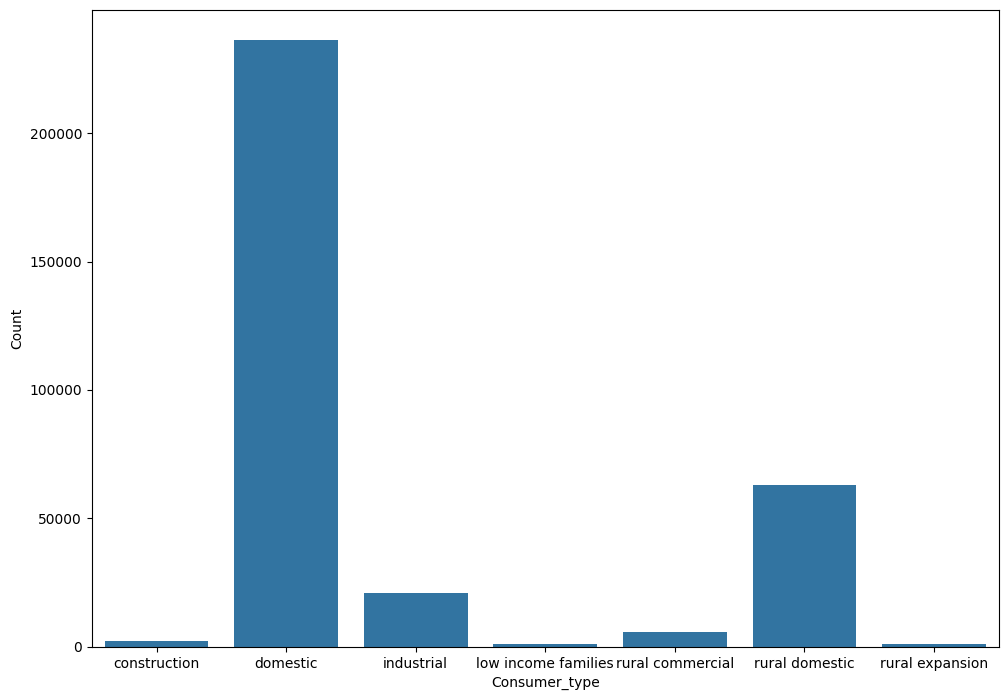

In [4]:
###########################
# try to solve unbalance class
# problem
###########################
unb = pd.DataFrame({'Count' : train.groupby( ["Consumer_type"] ).size()}).reset_index()
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(data=unb, x=unb["Consumer_type"], y=unb["Count"])

###########################
# problem: we have too many 
# domestic class
###########################

3.2) GENERATE DATA

generate synthetic data using a GAN network

In [ ]:
###########################
# load and divide dataframe
###########################
y = train[['Consumer_type']]
X = train[['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone']]

###########################
# encoding, transform into
# numbers all the categories
###########################
enc = OrdinalEncoder(dtype=np.int16)
X[['Consumer_number', 'Installation_zone']]= enc.fit_transform(X[['Consumer_number', 'Installation_zone']])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

real_data = pd.DataFrame(X, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
real_labels = y

print(real_labels.head())

# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(real_labels))

In [37]:
# Constants
NOISE_DIM = 100
NUM_CLASSES = 3
NUM_FEATURES = 4
BATCH_SIZE = 64
TRAINING_STEPS = 5000

# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

# Generate instances for a given class
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=['a', 'b', 'c', 'd'])

In [ ]:
# Create and compile the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
# Train GAN
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, real_data.shape[0], BATCH_SIZE)
    real_batch = real_data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 500 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

3.2) RANDOM FOREST

     create a rf model

In [14]:
###########################
# transform classes into numbers
###########################
def categoricalToNumerical(df, cols):
  enc = OrdinalEncoder(dtype=np.int16)
  df[cols]= enc.fit_transform(df[cols])

In [29]:
###########################
# preparing dataset, transform classes into numbers
# and separate test and its target
###########################

categoricalToNumerical(train, ['Consumer_type', 'Consumer_number', 'Installation_zone'])

train_target = train['Consumer_type']
train.drop(columns=['Consumer_type'],inplace=True)

train.head()


,Year,Month,Consumption,Consumer_number,Installation_zone
0,2013,1,0,7352,0
1,2013,1,6,12578,11
2,2013,1,1,9603,11
3,2013,1,13,4674,11
4,2013,1,5,423,11


In [30]:
### Import and Function
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)

rfc = RandomForestClassifier(
    ccp_alpha=0.01,
    n_jobs=-1,
    n_estimators=20,
    max_depth=10,
    random_state=42,
    oob_score=True,
    max_features=None,
    bootstrap=True,
)

# Create the parameter grids
parameter_grid = {
    #"n_estimators": [10, 25, 50],
    #"max_depth": [10, 30, None],
    # "max_features": ["sqrt", "log2", None],
    #"criterion": ["gini", "entropy", "log_loss"]
    # "oob_score": [True, False]
    #'random_state': [0, 10],
    #'min_samples_leaf':[1, 4, 8],
    #'min_samples_split': [2, 6, 10],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=2)
cross_validation.get_n_splits(train, train_target)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=3,
    scoring=SCORING,
    return_train_score=True,
    refit="balanced_accuracy",
)

grid_search.fit(train, train_target)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/2] END  accuracy: (train=0.913, test=0.913) balanced_accuracy: (train=0.286, test=0.286) f1: (train=0.275, test=0.276) total time=   3.7s


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/2] END  accuracy: (train=0.913, test=0.913) balanced_accuracy: (train=0.286, test=0.286) f1: (train=0.276, test=0.275) total time=   3.3s


c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(ccp_alpha=0.01, max_depth=10,
                                              max_features=None,
                                              n_estimators=20, n_jobs=-1,
                                              oob_score=True, random_state=42),
             param_grid={}, refit='balanced_accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro'},
             verbose=3)

In [31]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.2855806218581516
Best parameters: {}


RandomForestClassifier(ccp_alpha=0.01, max_depth=10, max_features=None,
                       n_estimators=20, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
my_model = best_dtc
my_model.fit(train, train_target)
my_model.score(train, train_target)